In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
print(tf.__version__)

2.18.0


In [2]:
data_path = "TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [3]:
print("Min Intensity ",data_info.Vmax.min())
print("Max Intensity ",data_info.Vmax.max())
print("Mean Intensity ",round(data_info.Vmax.mean(),2))

Min Intensity  15.0
Max Intensity  155.0
Mean Intensity  48.14


In [4]:
np.shape(data_matrix)

(4580, 201, 201, 4)

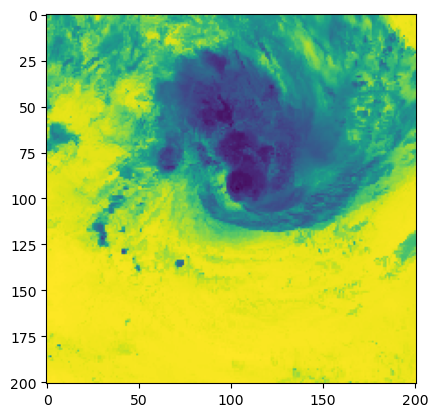

In [5]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img)

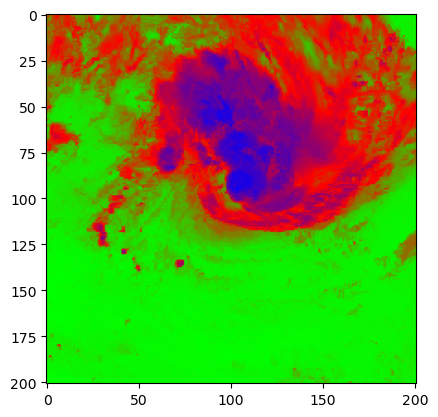

In [6]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.brg)

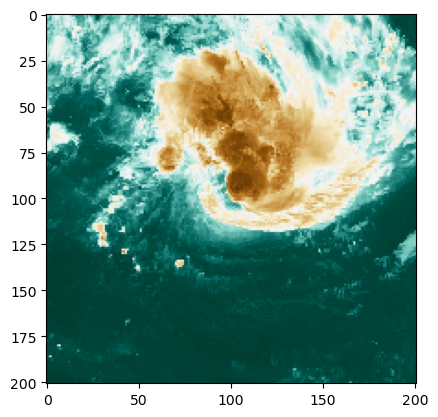

In [7]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.BrBG)

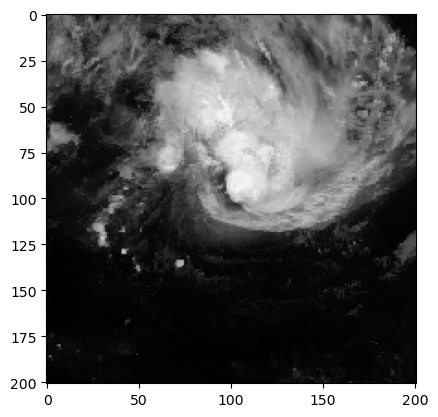

In [8]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.binary)

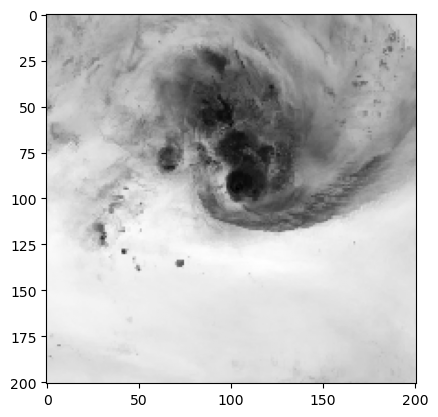

In [9]:
img = data_matrix[4000,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [10]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [11]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [12]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

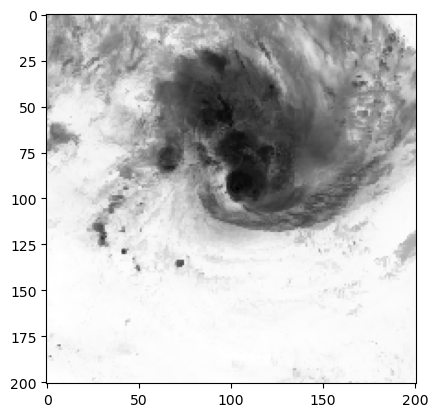

In [13]:
# X_std = tf.image.per_image_standardization(X_irpmw)
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [14]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

## Alexnet CNN

In [16]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=4,padding='valid', activation='relu', input_shape=(224,224,3)),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='relu'),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )
 
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model

In [17]:
model_history=[]
val_scores=[]
n_epochs=20
batch_size=256
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

C:\Users\shrey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20

15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 950ms/step - loss: 86887.3828 - mean_squared_error: 86887.3828
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 963ms/step - loss: 867.2089 - mean_squared_error: 867.2089
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 858.4869 - mean_squared_error: 858.4869
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 872.1707 - mean_squared_error: 872.1707
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 976ms/step - loss: 835.0155 - mean_squared_error: 835.0155
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 967ms/step - loss: 793.4752 - mean_squared_error: 793.4752
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 766.7113 - mean_squared_error: 766.7113
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 974ms/step - loss: 651.5826 - mean_squared_error: 651.5826
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 622.7874 - mean_squared_error: 622.7874
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 962ms/step - loss: 618.1403 - mean_squared_error: 618.1

In [18]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)

print('Test accuracy:', score[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Testing...
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 442.8748 - mean_squared_error: 442.8748
Test accuracy: 409.3000183105469


In [19]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

C:\Users\shrey\AppData\Local\Temp\ipykernel_5996\2544756279.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  abcd.append(int(x))


In [20]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [21]:
cate_dataset = list(zip(abcd,cate))

In [22]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [23]:
df

,Intensity,Category
0,59,Tropical Storm
1,41,Tropical Storm
2,31,Tropical Depression
3,46,Tropical Storm
4,47,Tropical Storm
...,...,...
408,29,Tropical Depression
409,37,Tropical Storm
410,33,Tropical Depression
411,33,Tropical Depression


## Deep CNN

In [25]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model


In [26]:
model_history=[]
val_scores=[]
n_epochs=10
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1223.7229 - mean_squared_error: 1223.7151
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 767.1747 - mean_squared_error: 767.1677
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 599.3914 - mean_squared_error: 599.3848
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 479.4308 - mean_squared_error: 479.4246
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 407.3166 - mean_squared_error: 407.3104
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 401.5713 - mean_squared_error: 401.5650
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 355.2863 - mean_squared_error: 355.2799
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 332.8328 - mean_squared_error: 332.8265
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 326.4463 - mean_squared_error: 326.4399
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 320.4467 - mean_squared_error: 320.4403
15/15 ━

In [27]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 303.2621 - mean_squared_error: 303.2557
Test accuracy: 304.04766845703125


In [28]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

C:\Users\shrey\AppData\Local\Temp\ipykernel_5996\2544756279.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  abcd.append(int(x))


In [29]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [30]:
cate_dataset = list(zip(abcd,cate))

In [31]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [32]:
df

,Intensity,Category
0,60,Tropical Storm
1,23,Tropical Depression
2,23,Tropical Depression
3,56,Tropical Storm
4,31,Tropical Depression
...,...,...
408,36,Tropical Storm
409,33,Tropical Depression
410,32,Tropical Depression
411,29,Tropical Depression


## Kfold 

In [34]:
n_epochs=5
batch_size=32
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3348.2419 - mean_squared_error: 3348.2354
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 630.4264 - mean_squared_error: 630.4211
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 546.3843 - mean_squared_error: 546.3798
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 537.8321 - mean_squared_error: 537.8274
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 431.8650 - mean_squared_error: 431.8602
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 578.9287 - mean_squared_error: 578.9240
Val Score:  [642.3042602539062, 642.2996215820312]


Training on Fold:  2
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1388.7450 - mean_squared_error: 1388.7374
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 937.1282 - mean_squared_error: 937.1220
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 811.9720 - mean_squared_error: 811.9664
Epoch 4/5
96/96 ━━━━━━━━━━━━━━

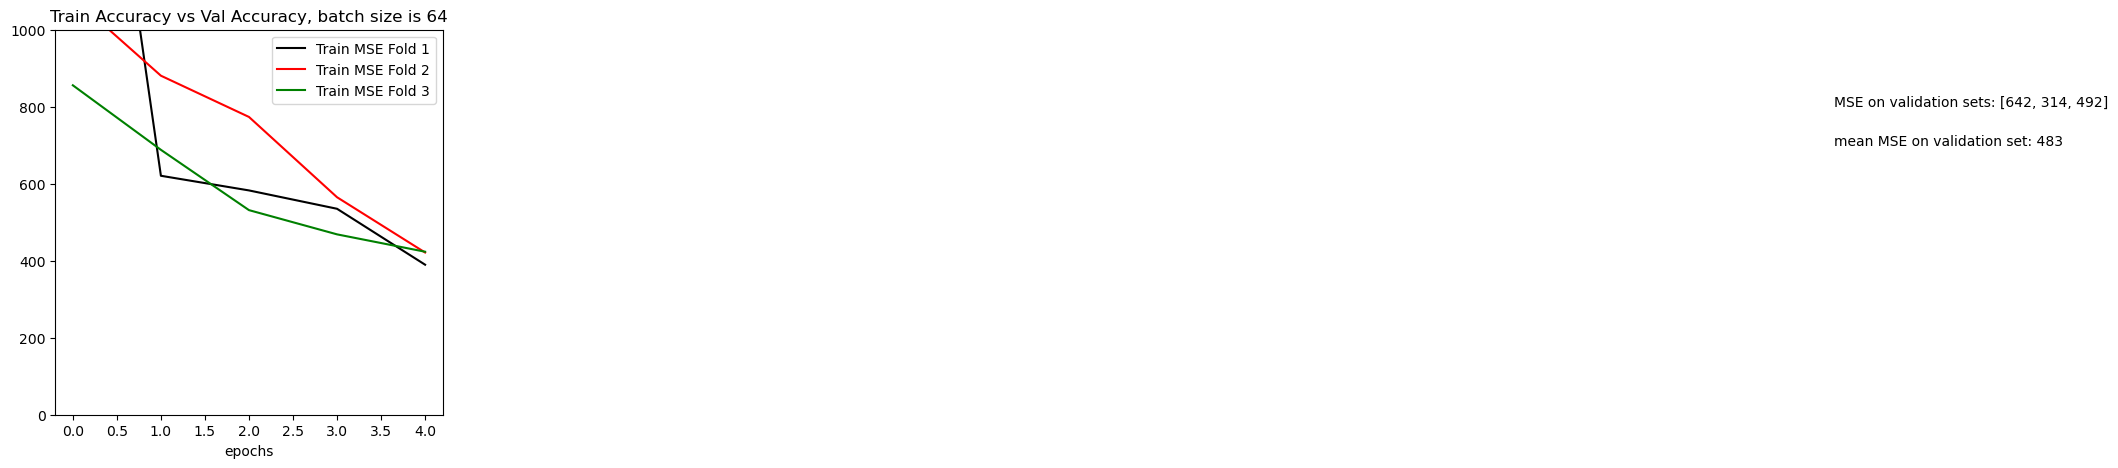

In [35]:
plt.figure(figsize=(5,5))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
#     plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()